# Fine Tuning YOLO on a Custom Dataset
This notebook creates a custom dataset of randomly sized and colored circles and triangles along with an annotation file formatted for YOLO. It then uses that data to perform fine tuning on one of the pre-trained models and displays the results.

First let's import all the libraries we'll need for the notebook.

In [1]:
import cv2
import numpy as np
import os
import shutil 
from IPython.display import Image, display, Code
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
%matplotlib inline

## Create the Dataset
Create a dataset of randomly sized and colored circles and triangles.

In [2]:
# Specify a root location for the dataset
DATA_DIR = "./datasets"

# Specify the hight and width of the images in the dataset (640 is the default YOLO size)
(IMG_WIDTH, IMG_HEIGHT) = (640, 640)

In [3]:
def delete_dirs(dirs=[]):
    """Deletes a list of directories

    Args:
        dirs (list, optional): The directories to delete. Defaults to [].
    """

    for dir in dirs:
        if os.path.exists(dir):
            shutil.rmtree(dir) 

# Delete folders generated during previous training cycles
delete_dirs(['runs/detect', f'{DATA_DIR}/test', f'{DATA_DIR}/train', f'{DATA_DIR}/val'])

In [4]:
def get_yolo_annotations(x1, y1, x2, y2, image_width, image_height):
    """Convert bounding box annotations to YOLO annotations that are resilient to image resizing.

    Args:
        x1 (int): The pixel coordinate for the left hand side of the bounding box
        y1 (int): The pixel coordinate for the top of the bounding box
        x2 (int): The pixel coordinate for the right hand side of the bounding box
        y2 (int): The pixel coordinate for the bottom of the bounding box
        image_width (int): The width of the image
        image_height (int): The height of the image

    Returns:
        center_x (float): The distance of the bounding box's center from the left side of the image. Expressed in the range of 0.0 to 1.0.
        center_y (float): The distance of the bounding box's center from the top of the image. Expressed in the range of 0.0 to 1.0.
        width (float):    The percentage of the image's width that the bounding box occupies. Expressed in the range of 0.0 to 1.0.
        height (float):   The percentage of the image's height that the bounding box occupies. Expressed in the range of 0.0 to 1.0.
    """

    center_x = (x2+x1)/2/image_width
    center_y = (y2+y1)/2/image_height
    width    = (x2-x1)/image_width
    height   = (y2-y1)/image_height
    
    return center_x, center_y, width, height

In [5]:
def write_yolo_annotations(x1, y1, x2, y2, image_width, image_height, class_id, label_file):
    """Convert the bounding box annotations to YOLO format and write to a file.

    Args:
        x1 (int): The pixel coordinate for the left hand side of the bounding box
        y1 (int): The pixel coordinate for the top of the bounding box
        x2 (int): The pixel coordinate for the right hand side of the bounding box
        y2 (int): The pixel coordinate for the bottom of the bounding box
        image_width (int): The width of the image
        image_height (int): The height of the image
        class_id (int): A unique integer associated with the class
        label_file (string): The file location to write the annotations
    """
    
    # Get YOLO annotations
    center_x, center_y, width, height = get_yolo_annotations(x1, y1, x2, y2, image_width, image_height)

    # Make sure values are reasonable
    if center_x > 0 and center_y > 0 and width > 0 and height > 0 and \
       center_x <= 1 and center_y <= 1 and width <= 1 and height <= 1:
        
        # Write the annotations
        f = open(label_file, 'a')
        f.write('{} {} {} {} {}\n'.format(class_id, center_x, center_y, width, height))
        f.close()
    else:
        print(f"At least a portion of the class is outside the image boundary ({center_x}, {center_y}, {width}, {height})")

In [6]:
def draw_random_circle(img):
    """Draws a randomly sized and colored circle on an image

    Args:
        img (array): The image to modify

    Returns:
        center_x (int): The x coordinate for the center of the circle
        center_y (int): The y coordinate for the center of the circle
        radius (int): The radius of the circle
    """
    
    radius   = np.random.randint(10, 100)
    center_x = np.random.randint(radius, IMG_WIDTH-radius)
    center_y = np.random.randint(radius, IMG_HEIGHT-radius)
    color    = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    
    cv2.circle(img, (center_x, center_y), radius, color, -1)

    return center_x, center_y, radius

In [7]:
def draw_random_triangle(img):
    """Draws a randomly sized and colored triangle on an image

    Args:
        img (array): The image to modify

    Returns:
        lhs (int): The x coordinate for the center of the circle
        rhs (int): The y coordinate for the center of the circle
        top (int): The radius of the circle
        bottom (int) :
    """

    # get a random point in the image at least 100 pixels from the border
    pt1 = (np.random.randint(100, IMG_WIDTH-100), np.random.randint(100, IMG_HEIGHT-100))
    # get a second point 50 to 100 pixels from the first point 
    pt2 = (pt1[0]+np.random.randint(50, 100), pt1[1]+np.random.randint(50, 100))
    # get a third point 50 to 100 pixels from the first point
    pt3 = (pt1[0]-np.random.randint(50, 100), pt1[1]+np.random.randint(50, 100))

    triangle = np.array( [pt1, pt2, pt3] )

    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    
    cv2.drawContours(img, [triangle], 0, color, -1)

    x_vals = [x[0] for x in triangle]
    y_vals = [x[1] for x in triangle]

    lhs = np.min(x_vals)
    rhs = np.max(x_vals)
    top = np.min(y_vals)
    bottom = np.max(y_vals)

    return lhs, rhs, top, bottom

In [8]:
CIRCLE_CLASS_ID   = 0
TRIANGLE_CLASS_ID = 1

def create_data(dir, num_images):
    """Populates a directory with a dataset

    Args:
        dir (string): The root directory of the dataset
        num_images (ing): The number of images in the dataset
    """
    
    img_dir   = os.path.join(DATA_DIR, dir, "images")
    label_dir = os.path.join(DATA_DIR, dir, "labels")
    os.makedirs(img_dir,   exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i in range(num_images):
        img = np.random.randint(0, 255, (IMG_HEIGHT, IMG_WIDTH, 3), "uint8")
        img_file   = "{}/{}.jpg".format(img_dir,   i)
        label_file = "{}/{}.txt".format(label_dir, i)

        center_x, center_y, radius = draw_random_circle(img)
        write_yolo_annotations(center_x-radius, center_y-radius, center_x+radius, center_y+radius, IMG_WIDTH, IMG_HEIGHT, CIRCLE_CLASS_ID, label_file)

        x_min, x_max, y_min, y_max = draw_random_triangle(img)
        write_yolo_annotations(x_min, y_min, x_max, y_max, IMG_WIDTH, IMG_HEIGHT, TRIANGLE_CLASS_ID, label_file)

        cv2.imwrite(img_file, img)

Let's use these methods we just created to make our dataset.

In [9]:
create_data("train", 150)
create_data("test" ,  25)
create_data("val"  ,   9)

Let's print out one of our validation images and annotations to make sure everything looks good.

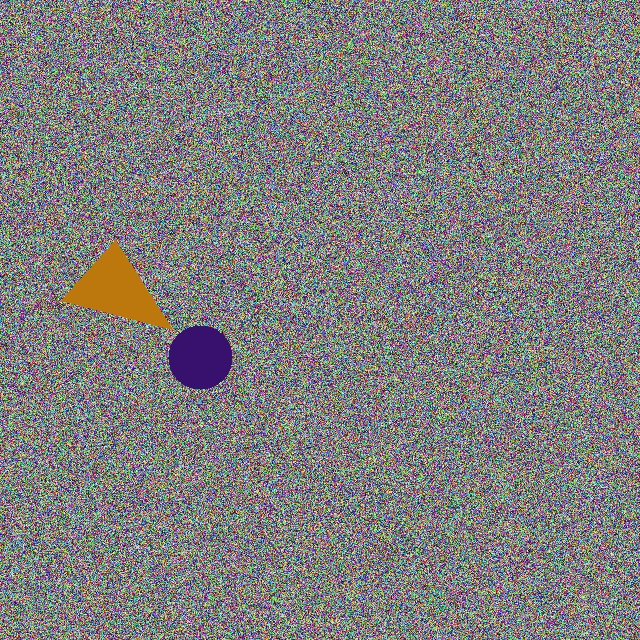

0 0.3125 0.5578125 0.1 0.1
1 0.18203125 0.44453125 0.1734375 0.1390625

In [10]:
val_images_dir = 'datasets/val/images/'
val_anno_dir   = 'datasets/val/labels/'

images = [f"{val_images_dir}{image}" for image in os.listdir(val_images_dir)]
labels = [f"{val_anno_dir}{label}" for label in os.listdir(val_anno_dir)]
images.sort()
labels.sort()

# Display the image
display(Image(images[0]))

# Display the annotations
Code(filename=labels[0], language='console')

# Train the Model

In [11]:
def create_config_file(config_file):
    """Creates and writes a YOLO config file necessary for training. 

    Args:
        config_file (str): The filename.'.
    """

    if not os.path.exists(config_file):
        f = open(config_file, "x")
        f.write('''\
# Train and test folders
train: 'train'
val: 'test'

# Number of classes
nc: 2
names: ['circle', 'triangle']''')
        f.close()

config_file = 'object_v11.yaml'
create_config_file(config_file)

In [12]:
# Initialize the YOLO model and print out the supported classes
YOLO_MODEL = 'yolo12n'
model = YOLO('{}.pt'.format(YOLO_MODEL))

print(model.names.values())

dict_values(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'])


In [13]:
# Start the training
_ = model.train(
    data = config_file,
    imgsz = 640,
    epochs = 50,
    batch = 32,
    #device='cpu',
    name = YOLO_MODEL
)

Ultralytics 8.3.94 🚀 Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11169MiB)
engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=object_v11.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo12n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

E0000 00:00:1742750052.287501  952465 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742750052.354680  952465 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

train: Scanning /home/brian/Desktop/code/Demos/yolo/datasets/train/labels... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<00:00, 857.32it/s]

train: New cache created: /home/brian/Desktop/code/Demos/yolo/datasets/train/labels.cache



val: Scanning /home/brian/Desktop/code/Demos/yolo/datasets/test/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1527.13it/s]

val: New cache created: /home/brian/Desktop/code/Demos/yolo/datasets/test/labels.cache


Plotting labels to runs/detect/yolo12n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo12n
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.23G      0.891      3.608      1.087         66        640: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all         25         50     0.0032       0.48      0.029     0.0177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.23G     0.9191      3.618      1.097         84        640: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         25         50    0.00551       0.82      0.149       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.23G     0.7076      2.937     0.9448         67        640: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         25         50    0.00654       0.98      0.579      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.23G     0.7184       1.82     0.9939         61        640: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         25         50     0.0064       0.96      0.817      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.23G     0.6524      1.192     0.9711         71        640: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all         25         50     0.0064       0.96      0.807      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.23G     0.6356      1.061     0.9549         76        640: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         25         50    0.00658       0.98      0.802      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.23G     0.6066      0.917     0.9239         74        640: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         25         50    0.00465        0.7      0.246      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.23G     0.6074      1.007     0.9418         55        640: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         25         50    0.00643       0.72      0.215      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.23G     0.5795     0.8954     0.9088         75        640: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         25         50          1      0.113      0.685      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.23G     0.6198     0.9184     0.9549         65        640: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         25         50      0.983      0.244      0.544      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.23G      0.577     0.7995     0.9139         74        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         25         50          1      0.186      0.596      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.23G     0.5614     0.8072     0.9014         75        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


                   all         25         50          1      0.144      0.645      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.23G     0.5556     0.7872     0.9318         62        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         25         50          1       0.11      0.679      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.23G     0.5259     0.7315     0.8981         68        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         25         50          1      0.118      0.734      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.23G     0.5475     0.7547     0.9283         59        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         25         50          1       0.23      0.765      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.23G     0.5256     0.7538     0.8997         58        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         25         50          1      0.576      0.777      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.23G     0.5265     0.7112     0.8742         70        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all         25         50      0.898      0.642      0.815      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.23G     0.4829     0.6732     0.8856         75        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         25         50      0.576      0.321      0.559      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.23G     0.5303     0.7149     0.9072         54        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         25         50      0.559      0.491      0.542      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.23G      0.518     0.6733     0.9072         67        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         25         50      0.941      0.759      0.941      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.23G      0.475      0.635     0.8877         70        640: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         25         50      0.966      0.773      0.889      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.23G     0.4788     0.6636     0.9194         61        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         25         50       0.96      0.756      0.883      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.23G     0.5024     0.6818      0.896         54        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         25         50      0.963       0.98      0.971      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.23G     0.4775     0.6231     0.8883         66        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         25         50      0.849      0.601      0.778      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.23G     0.4906     0.6221     0.8997         67        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         25         50      0.944      0.437      0.622      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.23G     0.4785     0.5841     0.8956         77        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         25         50          1      0.316      0.708      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.23G      0.502     0.5966     0.9072         62        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         25         50      0.987      0.742      0.969      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.23G     0.4194     0.5625     0.8617         52        640: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         25         50      0.982      0.894      0.979      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.23G     0.4323     0.5384     0.8752         64        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         25         50      0.978       0.92      0.985       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.23G     0.4444     0.5528     0.8898         71        640: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all         25         50      0.988      0.978      0.975      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.23G      0.398     0.5208      0.872         77        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         25         50      0.993       0.98      0.992      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.23G     0.3901     0.4919     0.8685         78        640: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         25         50      0.996       0.98      0.994      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.23G     0.4011     0.5189     0.8631         61        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         25         50      0.995       0.98      0.994      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.23G     0.3933     0.5053     0.8652         63        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         25         50      0.994       0.98      0.989      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.23G     0.4073      0.489     0.8852         68        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         25         50      0.996       0.98      0.992      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.23G     0.3785     0.4958      0.871         54        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         25         50      0.995       0.98      0.991      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.23G     0.3759      0.484     0.8505         71        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         25         50      0.984      0.999      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.23G     0.4002     0.4859     0.8715         47        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         25         50      0.982      0.998      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.23G     0.3811     0.4512     0.8656         60        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         25         50      0.982      0.996      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.23G     0.3677     0.4321     0.8532         80        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         25         50      0.983      0.998      0.995       0.95


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.23G     0.2887     0.4558     0.8354         44        640: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         25         50      0.987      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.23G      0.281     0.4576     0.8161         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         25         50      0.994       0.98      0.989      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.23G     0.2786     0.4428     0.8141         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         25         50      0.986      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.23G     0.2875     0.4439     0.8242         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         25         50      0.986      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.23G     0.2464     0.4167     0.8058         43        640: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         25         50      0.986      0.999      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.23G     0.2591     0.4136     0.8148         44        640: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         25         50      0.987      0.999      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.23G     0.2577     0.4069     0.8231         43        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         25         50      0.987      0.999      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.23G     0.2346     0.3934     0.8058         40        640: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         25         50      0.985      0.999      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.23G     0.2329       0.38     0.8049         43        640: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         25         50      0.985      0.999      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.23G     0.2263     0.3802     0.8009         43        640: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         25         50      0.984      0.999      0.995      0.975



50 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/yolo12n/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo12n/weights/best.pt, 5.5MB

Validating runs/detect/yolo12n/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11169MiB)
YOLOv12n summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


                   all         25         50      0.984      0.999      0.995      0.975
                circle         25         25          1      0.997      0.995      0.959
              triangle         25         25      0.968          1      0.995      0.991
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/yolo12n


In [14]:
# Display the classes the model supports now
print(model.names)

{0: 'circle', 1: 'triangle'}


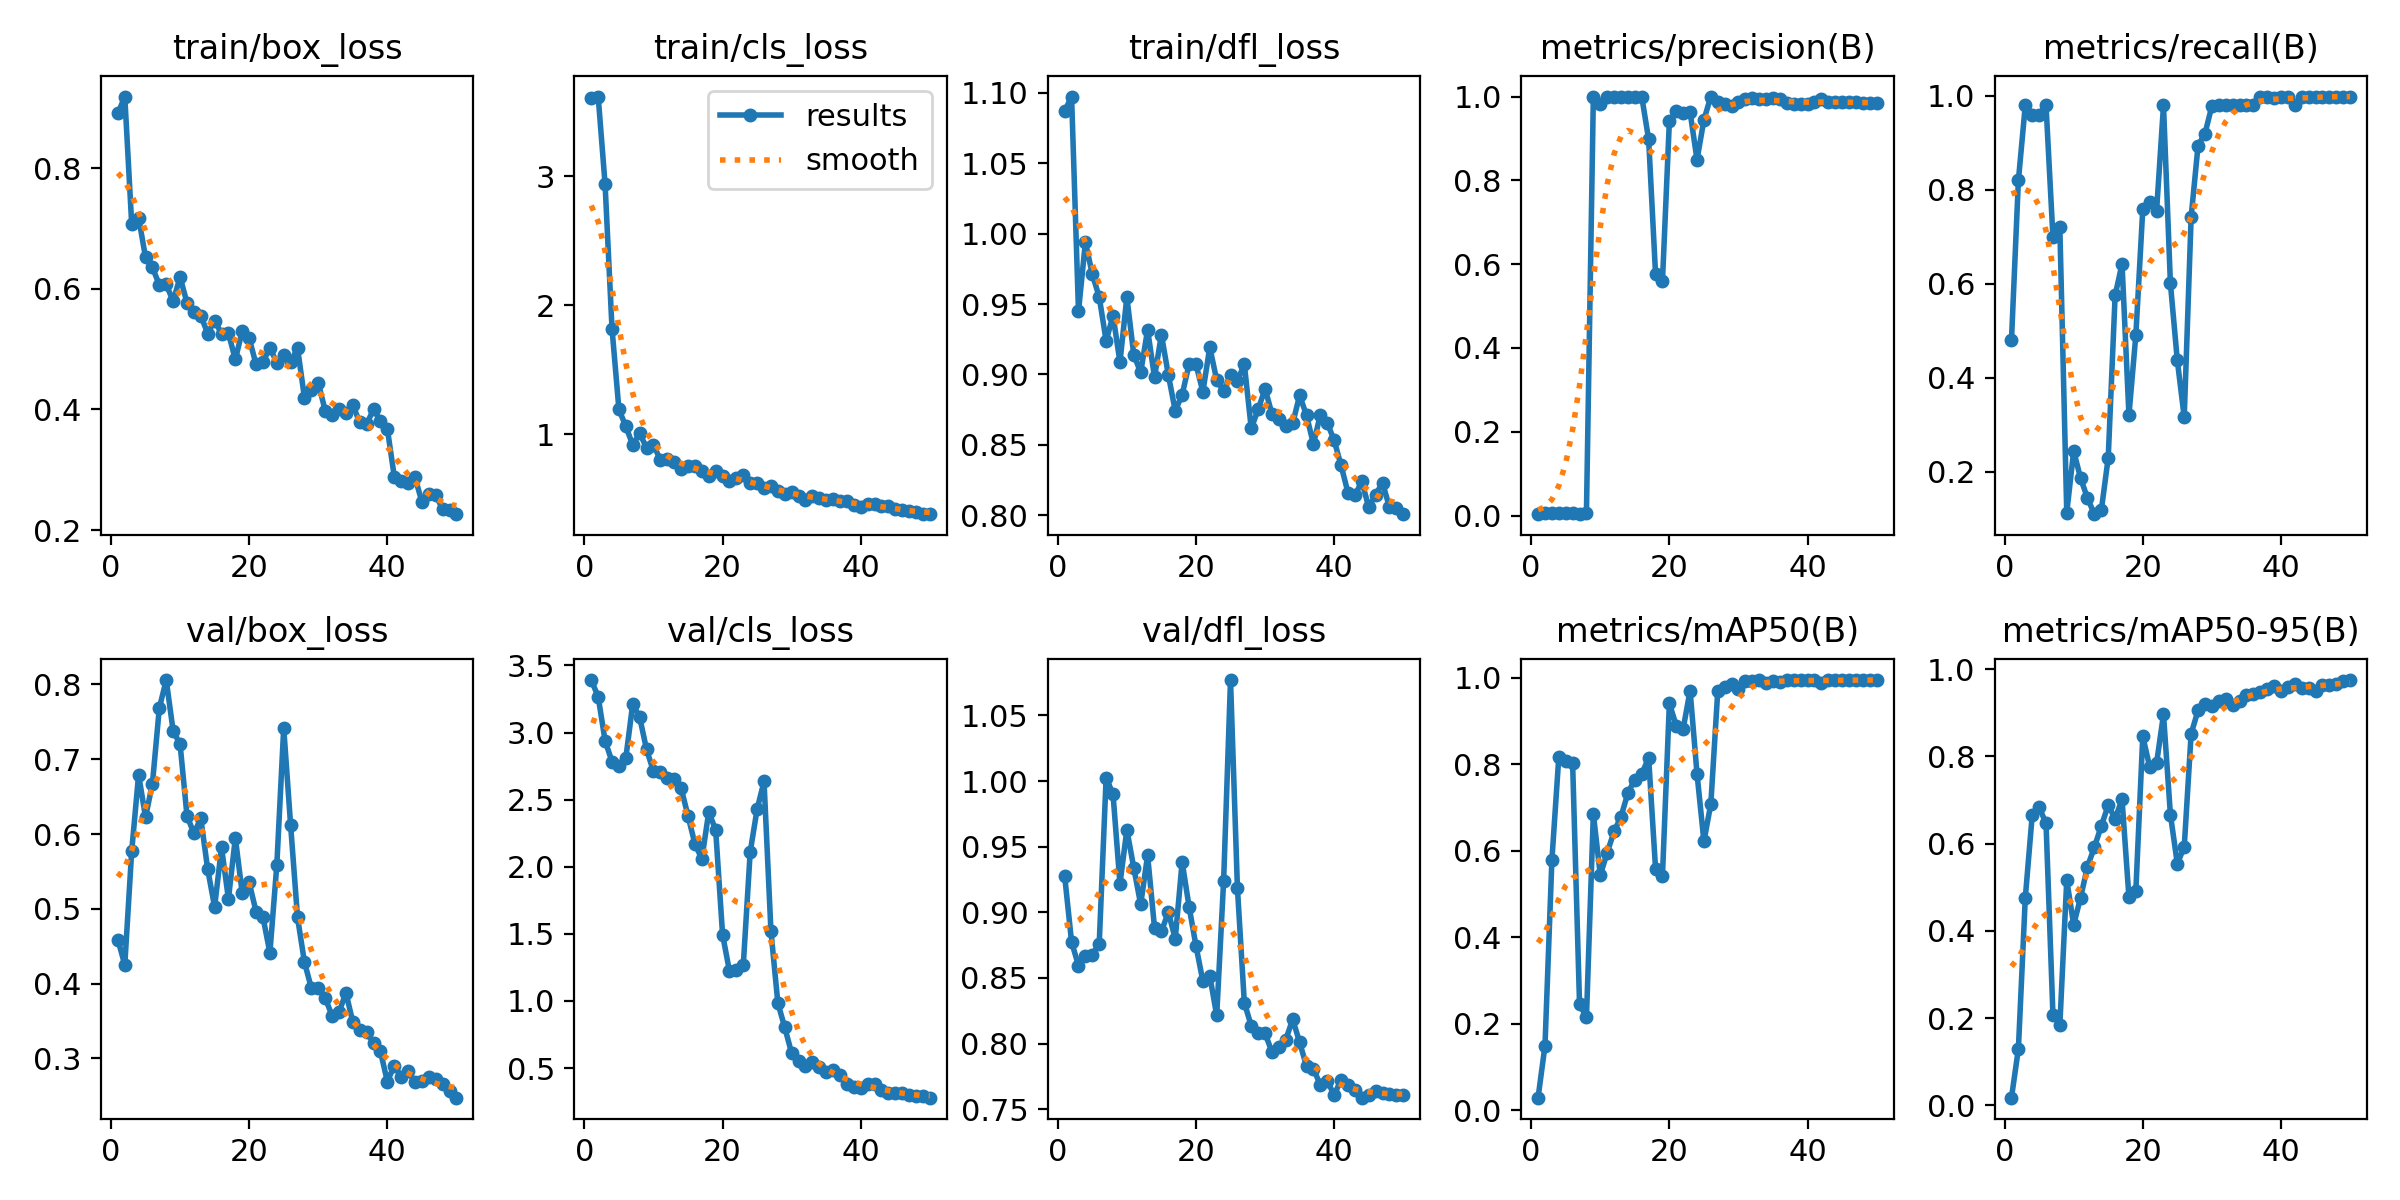

In [15]:
# Display the training characteristics
display(Image(f'runs/detect/{YOLO_MODEL}/results.png'))

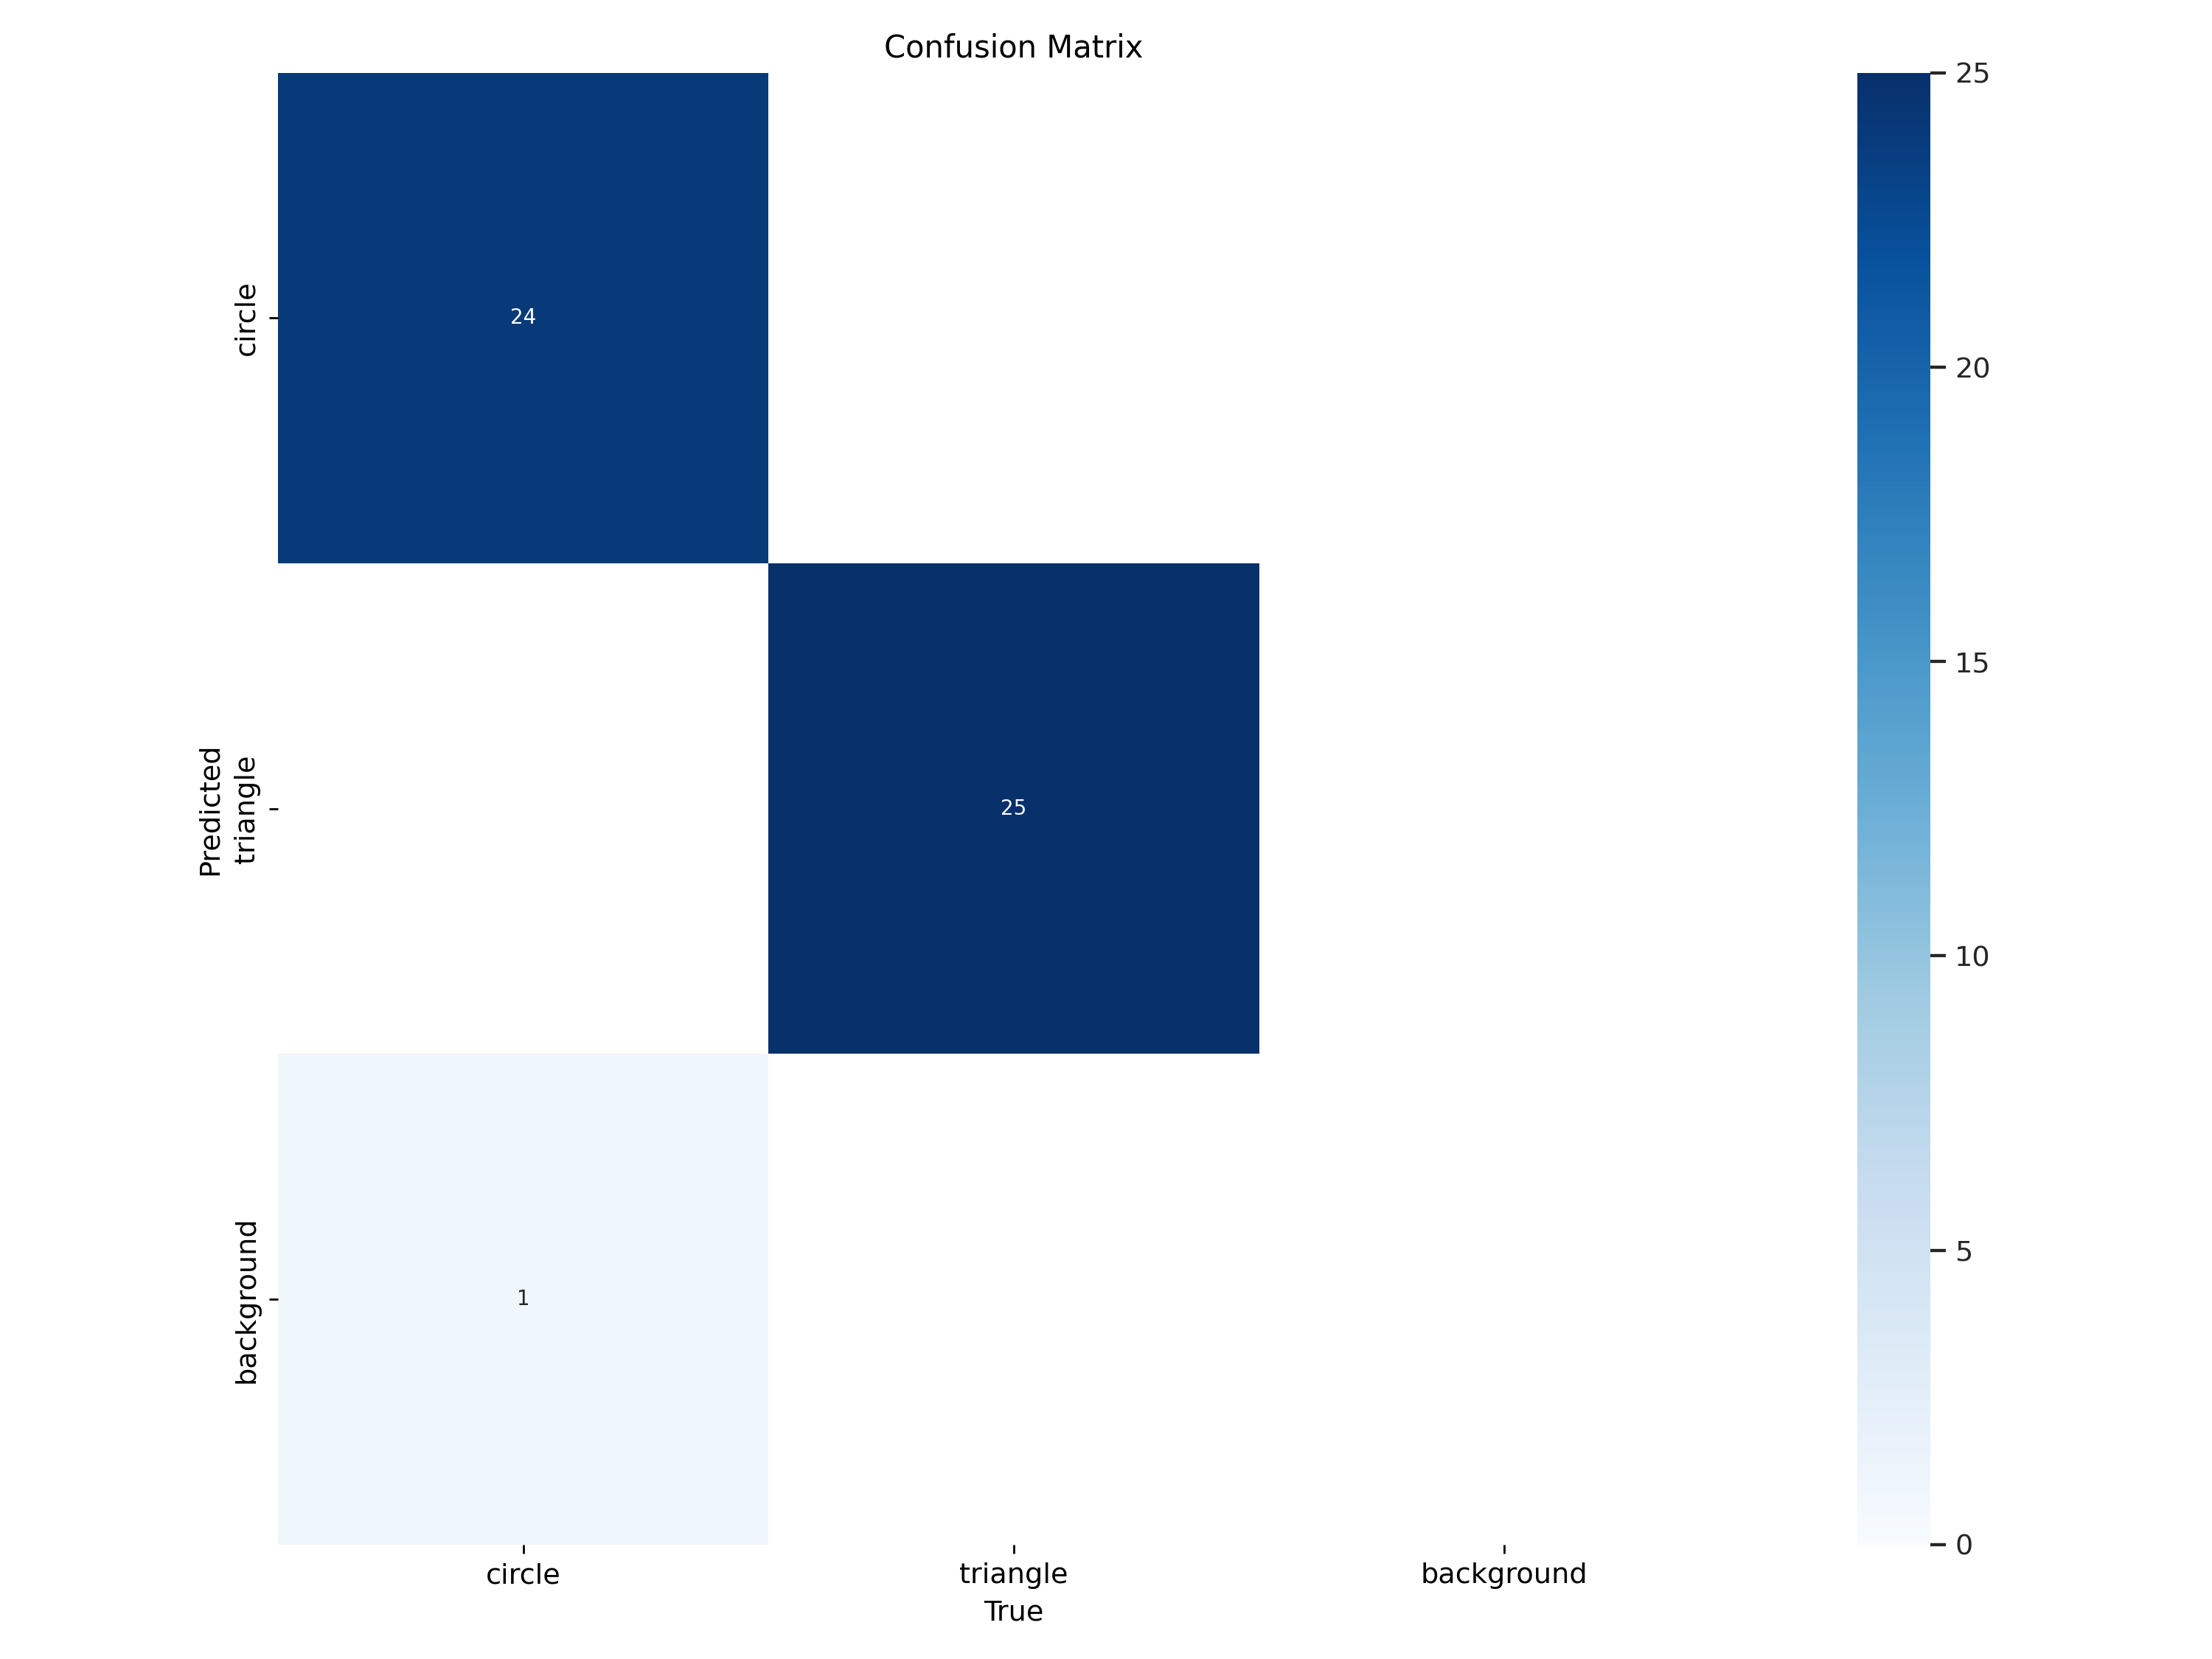

In [16]:
# Display the training characteristics
display(Image(f'runs/detect/{YOLO_MODEL}/confusion_matrix.png', width=1000, height=1000))

## Run YOLO

Let's annotate some of the model's output to see how it does.

In [17]:
# Load the best model
best_yolo_model = f'runs/detect/{YOLO_MODEL}/weights/best.pt'
model = YOLO(best_yolo_model)

# Load the paths to the validation images
val_images_dir = f'{DATA_DIR}/val/images/'
test_images = [f"{val_images_dir}{image}" for image in os.listdir(val_images_dir)]
batch_size = 64

# Create annotators for bounding box and labels
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP_LEFT)

images = []

for i in range(0, len(test_images), batch_size):
    results = model.predict(test_images[i:i + batch_size])
    for result in results:
        detections = sv.Detections.from_ultralytics(result)
        img = cv2.imread(result.path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Annotate
        annotated_image = box_annotator.annotate(scene=img, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

        images.append(annotated_image)


0: 640x640 1 circle, 1 triangle, 4.1ms
1: 640x640 1 circle, 1 triangle, 4.1ms
2: 640x640 1 circle, 1 triangle, 4.1ms
3: 640x640 1 circle, 1 triangle, 4.1ms
4: 640x640 1 circle, 1 triangle, 4.1ms
5: 640x640 1 circle, 1 triangle, 4.1ms
6: 640x640 1 circle, 1 triangle, 4.1ms
7: 640x640 1 circle, 1 triangle, 4.1ms
8: 640x640 1 circle, 1 triangle, 4.1ms
Speed: 1.6ms preprocess, 4.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


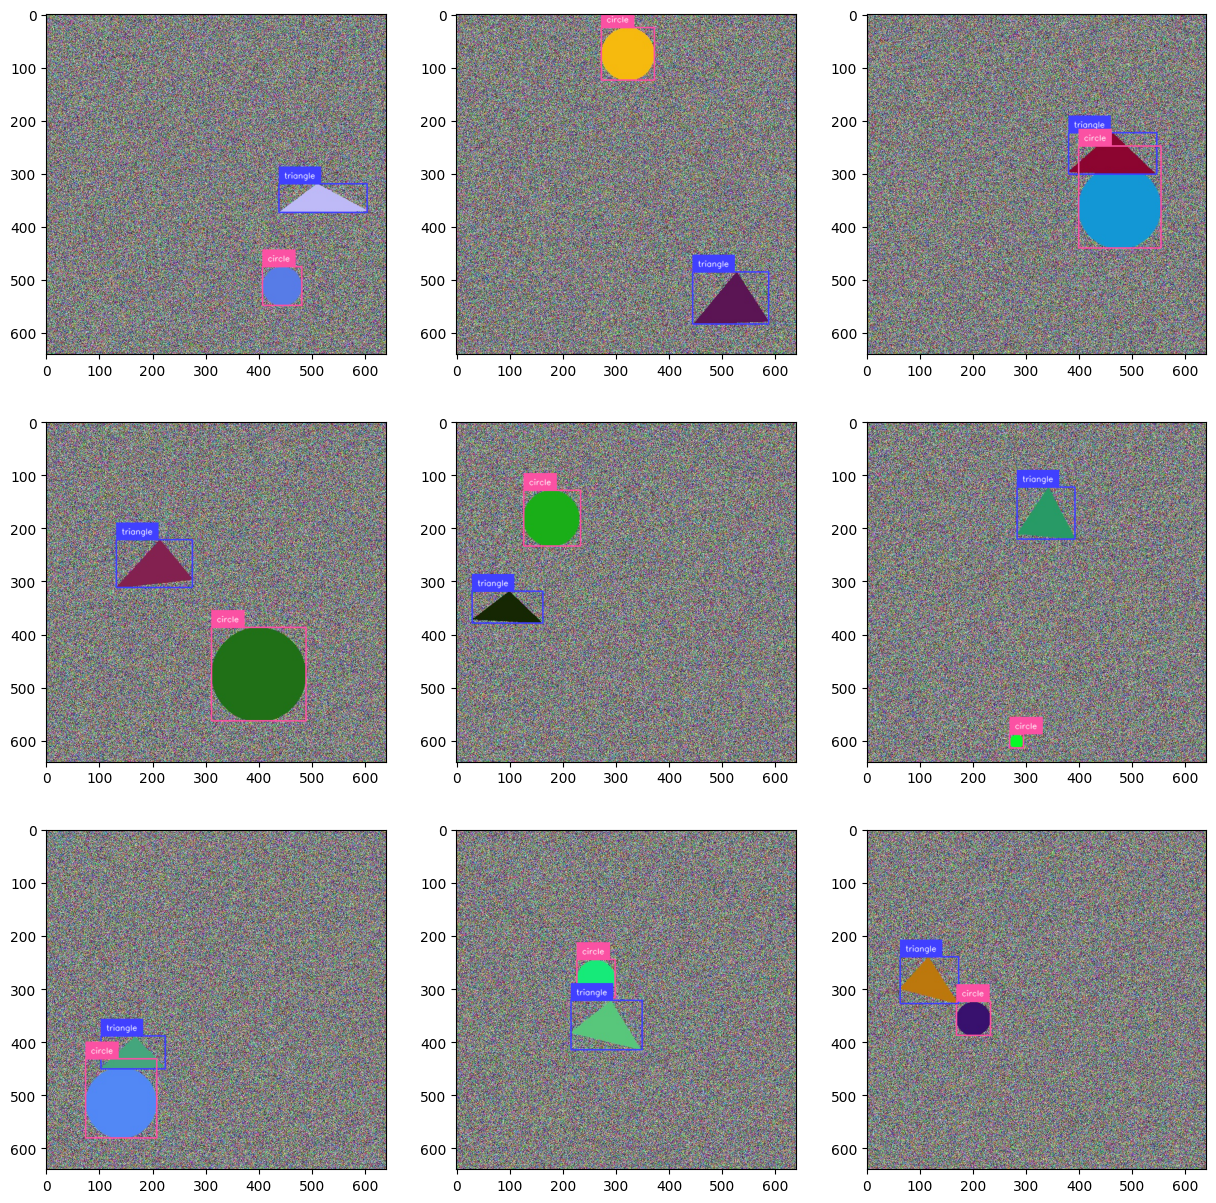

In [18]:
plt.figure(figsize=(15,15)) # specify the individual image size
#plt.figure(figsize=(15,15), dpi=1000) # specify the individual image size

for i in range(9):
    plt.subplot(3,3,i+1)    
    plt.imshow(images[i])

plt.show()